import

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import resample
import torch
from torch.utils.data import Dataset, DataLoader
import random


In [7]:
# -----------------------------
# Utilities
# -----------------------------
def set_seed(seed=0):
    np.random.seed(seed)
    random.seed(seed)
    try:
        import torch
        torch.manual_seed(seed)
    except:
        pass


In [8]:

# -----------------------------
# Physical model generators
# -----------------------------

def gen_1word_continuous(seq_len, rate_hz, params=None):
    """
    continuous physical signal (voltage/current-like)
    - params: dict with keys: freq, amplitude, drift, noise_std
    returns: ndarray shape (seq_len,) values in [0, 65535]
    """
    if params is None:
        params = {}
    t = np.arange(seq_len) / rate_hz
    freq = params.get('freq', np.random.uniform(0.1, 10.0))  # Hz
    amp = params.get('amplitude', np.random.uniform(500, 5000))
    drift = params.get('drift', np.random.uniform(-1.0, 1.0))  # slow drift per second
    noise_std = params.get('noise_std', np.random.uniform(0.1, 50.0))

    base = amp * np.sin(2 * np.pi * freq * t)
    # slow drift
    base = base + drift * t
    # random walk noise
    noise = np.random.normal(0, noise_std, size=seq_len)
    signal = base + np.cumsum(noise) * 0.01
    # scale + offset to 0-65535
    signal = signal - signal.min()
    if signal.max() == 0:
        signal = np.zeros_like(signal)
    else:
        signal = signal / (signal.max() + 1e-9) * 60000
    return np.clip(signal.astype(np.int64), 0, 65535)

def gen_2word_32bit_pair(seq_len, rate_hz, params=None):
    """
    Generate a 32-bit continuous-like value sequence and split into LSB(16) & MSB(16).
    Returns two arrays: lsb (16bit), msb (16bit)
    """
    if params is None:
        params = {}
    # generate a 32-bit like counter with noise and occasional jumps
    t = np.arange(seq_len) / rate_hz
    drift = params.get('drift', np.random.uniform(-0.5, 0.5))
    noise_std = params.get('noise_std', np.random.uniform(0.5, 50.0))
    base_freq = params.get('freq', np.random.uniform(0.01, 1.0))
    base = (np.sin(2 * np.pi * base_freq * t) + 1.0) * 1e6  # around ~1e6 scale
    # accumulate some noise to cause LSB increments / overflow behavior
    noise = np.random.normal(0, noise_std, seq_len).cumsum()
    raw32 = (base + drift * t * 1e3 + noise).astype(np.int64)
    raw32 = np.clip(raw32, 0, (1 << 32) - 1)
    lsb = (raw32 & 0xFFFF).astype(np.uint16)
    msb = ((raw32 >> 16) & 0xFFFF).astype(np.uint16)
    return lsb, msb, raw32

def gen_bits_field(seq_len, rate_hz, bit_width=8, params=None):
    """
    Generate bitfield-like values: bit_width in [1..16]
    Returns integer values in 0..(2^16-1) but only bit_start..bit_end vary.
    We'll simulate bit toggles using a 2-state Markov chain for each bit.
    """
    if params is None:
        params = {}
    p_same = params.get('p_same', 0.95)  # persistence of bit (higher -> rarely flip)
    start_bit = params.get('start_bit', 0)
    bit_width = int(bit_width)
    # generate each bit's timeline via Markov chain
    bits = np.zeros((bit_width, seq_len), dtype=np.uint8)
    # initial states random
    bits[:, 0] = (np.random.rand(bit_width) < 0.05).astype(np.uint8)
    for t in range(1, seq_len):
        flip = (np.random.rand(bit_width) > p_same).astype(np.uint8)
        bits[:, t] = np.bitwise_xor(bits[:, t-1], flip)
    # pack bits into 16-bit word at start_bit..start_bit+bit_width-1
    vals = np.zeros(seq_len, dtype=np.uint16)
    for b in range(bit_width):
        vals |= (bits[b] << (start_bit + b)).astype(np.uint16)
    return vals, start_bit, start_bit + bit_width - 1


# Realistic sensor data generation 11.24.
def gen_1word_realistic(length, rate_hz):
    t = np.arange(length) / rate_hz

    # Baseline & drift
    baseline = np.random.uniform(10000, 40000)
    drift_rate = np.random.uniform(-5, 5) / rate_hz
    drift = drift_rate * np.arange(length)

    # Multi-frequency vibration
    freqs = np.random.choice([3, 8, 15, 60, 120], size=np.random.randint(1, 3), replace=False)
    vib = np.zeros(length)
    for f in freqs:
        A = np.random.uniform(50, 500)
        phase = np.random.uniform(0, 2*np.pi)
        vib += A * np.sin(2 * np.pi * f * t + phase)

    # Mechanical resonance bump
    if np.random.rand() < 0.5:
        f_res = np.random.uniform(20, 40)
        Q = np.random.uniform(3, 8)
        resonance = 300 * np.sin(2*np.pi*f_res*t) * np.exp(-((t - t.mean())**2) * Q)
    else:
        resonance = 0

    # Noise: white + pink
    noise = np.random.normal(0, 20, length)
    pink = np.cumsum(np.random.normal(0, 0.1, length))  # low-frequency drift

    sig = baseline + drift + vib + resonance + noise + pink
    return np.clip(sig, 0, 65535).astype(np.int64)

def gen_2word_realistic(length, rate_hz):
    t = np.arange(length) / rate_hz

    base = np.random.uniform(10_000_000, 40_000_000)
    slow = np.random.uniform(-2000, 2000) * np.linspace(0, 1, length)

    # Low-frequency mechanical rotation / RPM simulation
    f_rpm = np.random.uniform(1, 5)
    vib = 20000 * np.sin(2*np.pi*f_rpm*t)

    # High-frequency components
    hf = np.random.uniform(1000, 5000) * np.sin(2*np.pi*50*t)

    noise = np.random.normal(0, 2000, length)

    raw32 = base + slow + vib + hf + noise
    raw32 = np.mod(raw32.astype(np.int64), 2**32)

    lsb = raw32 & 0xFFFF
    msb = (raw32 >> 16) & 0xFFFF
    return raw32, lsb.astype(np.int64), msb.astype(np.int64)

def gen_mixed_bitword(T, 
                      bit_prob=0.3, 
                      bits_prob=0.5, 
                      noise_bits=True):
    """
    하나의 16-bit 센서 워드를 생성.
    bit(1bit) + bits(연속비트) 혼합 지원.

    T : time length
    bit_prob : 단일 비트를 넣을 확률
    bits_prob : 연속된 bit 구간을 넣을 확률
    """
    word = np.zeros((T, 16), dtype=np.int32)

    meta = {
        "type": "mixed_bits",
        "bit_flag": None,
        "bits_range": None
    }

    # --- 1) 단일 bit flag 생성 ---
    if np.random.rand() < bit_prob:
        bit_pos = np.random.randint(0, 16)
        meta["bit_flag"] = bit_pos
        # random on/off 신호
        flag_signal = np.random.choice([0, 1], size=T)
        word[:, bit_pos] = flag_signal

    # --- 2) multi-bit 구간 생성 ---
    if np.random.rand() < bits_prob:
        start = np.random.randint(0, 14)
        end = np.random.randint(start + 1, 16)  # 최소 2bit 이상
        meta["bits_range"] = (start, end)

        # 카운터 또는 모드 변화처럼 생성
        num_bits = end - start + 1
        max_value = (1 << num_bits)

        counter = np.random.randint(0, max_value, size=T)
        for i in range(num_bits):
            bit_channel = (counter >> i) & 1
            word[:, start + i] = bit_channel

    # --- 3) noise bits (현실계 유사) ---
    if noise_bits:
        noise = np.random.choice([0,1], size=(T,16), p=[0.98,0.02])
        # 단, 이미 의미 있는 bit는 덮어쓰지 않음
        mask = (word == 0)
        word = word | (noise * mask)

    return word, meta

# -----------------------------
# Anomaly injection
# -----------------------------
def inject_anomalies(arr, rate_hz, anomaly_config=None):
    """
    arr: 1D numpy array (int)
    anomaly_config: dict with keys:
       - prob_segment: probability to inject a segment
       - seg_len_sec: (min_sec, max_sec)
       - types: ['spike','drift','stuck','noiseburst']
    """
    if anomaly_config is None:
        anomaly_config = {}
    prob = anomaly_config.get('prob_segment', 0.3)
    seg_range = anomaly_config.get('seg_len_sec', (0.05, 0.5))  # seconds
    types = anomaly_config.get('types', ['spike', 'drift', 'stuck', 'noiseburst'])
    arr = arr.copy().astype(np.float64)
    seq_len = arr.shape[0]
    t_sec = seq_len / rate_hz
    if np.random.rand() > prob:
        return arr.astype(np.int64), []  # no anomalies
    
    # choose number of segments 1~3
    n_seg = np.random.randint(1, 3)
    seg_infos = []
    for _ in range(n_seg):
        seg_dur = np.random.uniform(seg_range[0], seg_range[1])
        seg_len = max(1, int(seg_dur * rate_hz))
        start = np.random.randint(0, max(1, seq_len - seg_len))
        atype = random.choice(types)
        if atype == 'spike':
            mag = np.random.uniform(0.2, 0.8) * 60000
            arr[start:start+seg_len] += mag * np.exp(-np.linspace(0,3,seg_len))
        elif atype == 'drift':
            drift_val = np.linspace(0, np.random.uniform(100, 10000), seg_len)
            arr[start:start+seg_len] += drift_val
        elif atype == 'stuck':
            val = arr[start] + np.random.uniform(-100, 100)
            arr[start:start+seg_len] = val
        elif atype == 'noiseburst':
            arr[start:start+seg_len] += np.random.normal(0, np.random.uniform(500, 5000), seg_len)
        seg_infos.append({'start': start, 'len': seg_len, 'type': atype})
    arr = np.clip(arr, 0, 65535)
    return arr.astype(np.int64), seg_infos

# -----------------------------
# Main generator
# -----------------------------
def generate_multimodal_data_advanced(
    num_sensors=100,
    duration_sec=1.0,
    rates=[2000, 200, 50],
    prob_1word=0.4,
    prob_2word=0.3,
    prob_bits=0.3,
    seed=None,
    anomaly_cfg=None,
):
    """
    Generate sensors sampled at different rates and return:
      - sensors_by_rate: dict mapping rate -> list of sensor dicts
      - sensors_flat: flattened list of all sensor dicts (ids are unique)
    Each sensor dict contains:
      'id','type'(1/2/3), 'raw_rate', 'raw_len','raw_signal' (array),
      'meta', 'anomalies'
    Notes:
      - No alignment/resampling is performed here; raw signals keep their native rate.
      - Sensors are distributed evenly across the provided rates (remainder distributed one-by-one).
    """
    if seed is not None:
        set_seed(seed)

    # distribute sensors across rates (even split, distribute remainder)
    n_rates = len(rates)
    base = num_sensors // n_rates
    remainder = num_sensors % n_rates
    counts = [base + (1 if i < remainder else 0) for i in range(n_rates)]

    sensors_by_rate = {}
    sensors_flat = []
    global_id = 0

    for rate_idx, rate in enumerate(rates):
        cnt = counts[rate_idx]
        rate = int(rate)
        sensors_this_rate = []

        for _ in range(cnt):
            # choose sensor type by probabilities
            t = int(np.random.choice([1,2,3], p=[prob_1word, prob_2word, prob_bits]))
            raw_len = int(np.ceil(duration_sec * rate))
            meta = {}
            anomalies = []

            if t == 1:
                raw = gen_1word_realistic(raw_len, rate)
                raw, segs = inject_anomalies(raw, rate, anomaly_config=anomaly_cfg)
                anomalies = segs
                meta['type'] = '1word'
                meta['bit_start'] = 0
                meta['bit_end'] = 15
                raw = raw.astype(np.int64)

            elif t == 2:
                # gen_2word_realistic returns (raw32, lsb, msb)
                raw32, lsb, msb = gen_2word_realistic(raw_len, rate)
                # keep LSB as sensor raw value, keep MSB in meta
                raw = lsb.astype(np.int64)
                raw, segs = inject_anomalies(raw, rate, anomaly_config=anomaly_cfg)
                anomalies = segs
                meta['type'] = '2word_lsb'
                meta['pair_msb_signal'] = msb.astype(np.int64)
                meta['note'] = 'msb stored in meta; pairing info kept'

            elif t == 3:
                # create mixed bitword then pack to 16-bit integer per timestep
                word_bits, wmeta = gen_mixed_bitword(T=raw_len, bit_prob=0.5, bits_prob=0.5, noise_bits=True)
                # word_bits shape (T,16) -> pack to integer
                bit_weights = (1 << np.arange(16)).astype(np.int32)
                vals = (word_bits * bit_weights).sum(axis=1).astype(np.int64)
                raw, segs = inject_anomalies(vals, rate, anomaly_config=anomaly_cfg)
                anomalies = segs
                meta['type'] = 'bits'
                # extract start/end if available
                if wmeta.get('bits_range') is not None:
                    sbit, ebit = wmeta['bits_range']
                    meta['bit_start'] = sbit
                    meta['bit_end'] = ebit
                else:
                    meta['bit_start'] = 0
                    meta['bit_end'] = 15
                raw = raw.astype(np.int64)

            sensor = {
                'id': global_id,
                'type': t,
                'raw_rate': rate,
                'raw_len': raw_len,
                'raw_signal': raw,
                'meta': meta,
                'anomalies': anomalies
            }
            sensors_this_rate.append(sensor)
            sensors_flat.append(sensor)
            global_id += 1

        sensors_by_rate[rate] = sensors_this_rate

    return sensors_by_rate, sensors_flat


In [9]:

# -----------------------------
# PyTorch Dataset for MoE training
# -----------------------------
class MoEMultiSensorDataset(Dataset):
    """
    Each item corresponds to a single sensor (row).
    Returns a dict:
      {
        'id': int,
        'type': int,
        'raw_signal': torch.LongTensor shape (raw_len,)  (original rate)
        'aligned': torch.LongTensor shape (T,)
        'meta': meta dict
      }
    """
    def __init__(self, sensors, to_torch=True, dtype=torch.float32):
        self.sensors = sensors
        self.to_torch = to_torch
        self.dtype = dtype

    def __len__(self):
        return len(self.sensors)

    def __getitem__(self, idx):
        s = self.sensors[idx]
        item = {
            'id': s['id'],
            'type': s['type'],
            'meta': s['meta']
        }
        if self.to_torch:
            item['raw_signal'] = torch.from_numpy(s['raw_signal']).to(self.dtype)
            item['aligned'] = torch.from_numpy(s['aligned']).to(self.dtype)
        else:
            item['raw_signal'] = s['raw_signal']
            item['aligned'] = s['aligned']
        item['raw_rate'] = s['raw_rate']
        return item

# -----------------------------
# Visualization helpers
# -----------------------------
def plot_sensor_signal(sensor, which='aligned', ax=None):
    """
    sensor: dict from sensors list
    which: 'aligned' or 'raw'
    """
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(8,3))
    data = sensor['aligned'] if which == 'aligned' else sensor['raw_signal']
    ax.plot(data, linewidth=1)
    ax.set_title(f"Sensor {sensor['id']} type={sensor['type']} rate={sensor['raw_rate']} ({which})")
    return ax

def quick_summary(sensors):
    # accept either list or dict (rate->list)
    if isinstance(sensors, dict):
        sensors_list = [s for lst in sensors.values() for s in lst]
    else:
        sensors_list = sensors

    types = [s['type'] for s in sensors_list]
    unique, counts = np.unique(types, return_counts=True)
    print("Type distribution (1=1word,2=2word,3=bits):")
    for u,c in zip(unique, counts):
        print(f"  Type {u}: {c}")
    n_anom = sum([1 if len(s['anomalies'])>0 else 0 for s in sensors_list])
    print(f"Sensors with anomalies: {n_anom}/{len(sensors_list)}")
    print("Sample meta (first 5):")
    for s in sensors_list[:5]:
        print(s['id'], s['meta'])

def generate_multimodal_data(
    num_sensors=100,
    seq_len=200,
    prob_1word=0.4,
    prob_2word=0.3,
    prob_bits=0.3,
    seed=None
):
    """
    Generate randomized multimodal sensor data with labels and metadata.

    Returns:
        data: (num_sensors, seq_len) ndarray of int (0~65535)
        labels: list of sensor-type labels
            1 → 1word (16bit continuous)
            2 → 2word (MSB/LSB pair)
            3 → bits (partial bitfield)
        meta: list of metadata dictionaries per sensor
    """

    if seed is not None:
        np.random.seed(seed)

    data = np.zeros((num_sensors, seq_len), dtype=np.uint16)
    labels = []
    meta = []

    # Random type assignment
    sensor_types = np.random.choice(
        [1, 2, 3],
        size=num_sensors,
        p=[prob_1word, prob_2word, prob_bits]
    )

    # To track MSB-LSB pairing for 2-word sensors
    used_indices = set()

    for i in range(num_sensors):
        t = sensor_types[i]

        # -----------------------------------------
        # 1) 1WORD SENSOR (continuous 16bit signal)
        # -----------------------------------------
        if t == 1:
            base = np.random.uniform(0, 1)
            noise = np.random.normal(0, 0.03, seq_len)
            signal = base + np.cumsum(noise)  # random walk
            signal = np.clip(signal * 20000, 0, 65535)  # scale to 16bit
            data[i] = signal.astype(np.uint16)

            labels.append(1)
            meta.append({
                "type": "1word",
                "bit_start": 0,
                "bit_end": 15
            })

        # -----------------------------------------
        # 2) 2WORD SENSOR (32bit: MSB/LSB pairing)
        # -----------------------------------------
        elif t == 2:

            # If already used as MSB or LSB, skip (meta is created earlier)
            if i in used_indices:
                continue

            # Ensure valid index for MSB-LSB pair
            if i < num_sensors - 1:
                lsb_idx = i
                msb_idx = i + 1

                used_indices.add(lsb_idx)
                used_indices.add(msb_idx)

                labels.extend([2, 2])  # two rows represent one 32-bit sensor

                meta.append({
                    "type": "2word",
                    "role": "LSB",
                    "pair": msb_idx
                })
                meta.append({
                    "type": "2word",
                    "role": "MSB",
                    "pair": lsb_idx
                })

                # Generate continuous 32bit increasing signal
                base = np.random.uniform(0, 10)
                noise = np.random.normal(0, 0.5, seq_len)
                signal32 = base + np.cumsum(noise)
                signal32 = np.clip(signal32 * 5000, 0, (1 << 32) - 1).astype(np.uint32)

                # Split into LSB(16bit), MSB(16bit)
                lsb = signal32 & 0xFFFF
                msb = (signal32 >> 16) & 0xFFFF

                data[lsb_idx] = lsb.astype(np.uint16)
                data[msb_idx] = msb.astype(np.uint16)

            else:
                # If last index, fallback → treat as 1word
                labels.append(1)
                base = np.random.uniform(0, 1)
                noise = np.random.normal(0, 0.03, seq_len)
                signal = base + np.cumsum(noise)
                signal = np.clip(signal * 20000, 0, 65535)
                data[i] = signal.astype(np.uint16)
                meta.append({
                    "type": "fallback_1word_due_to_boundary"
                })

        # -----------------------------------------
        # 3) BITFIELD SENSOR (1~15bits)
        # -----------------------------------------
        elif t == 3:
            bit_width = np.random.randint(1, 16)  # 1~15 bits
            start_bit = np.random.randint(0, 16 - bit_width)
            end_bit = start_bit + bit_width - 1

            # Generate random toggle/control signal
            toggles = np.random.choice([0, 1], size=seq_len, p=[0.9, 0.1])
            value = toggles.astype(np.uint16) << start_bit

            data[i] = value

            labels.append(3)
            meta.append({
                "type": "bits",
                "bit_start": start_bit,
                "bit_end": end_bit,
                "bit_width": bit_width
            })

    return data, labels, meta



Type distribution (1=1word,2=2word,3=bits):
  Type 1: 177
  Type 2: 5
  Type 3: 18
Sensors with anomalies: 129/200
Sample meta (first 5):
0 {'type': '1word', 'bit_start': 0, 'bit_end': 15}
1 {'type': '1word', 'bit_start': 0, 'bit_end': 15}
2 {'type': '1word', 'bit_start': 0, 'bit_end': 15}
3 {'type': '1word', 'bit_start': 0, 'bit_end': 15}
4 {'type': '1word', 'bit_start': 0, 'bit_end': 15}


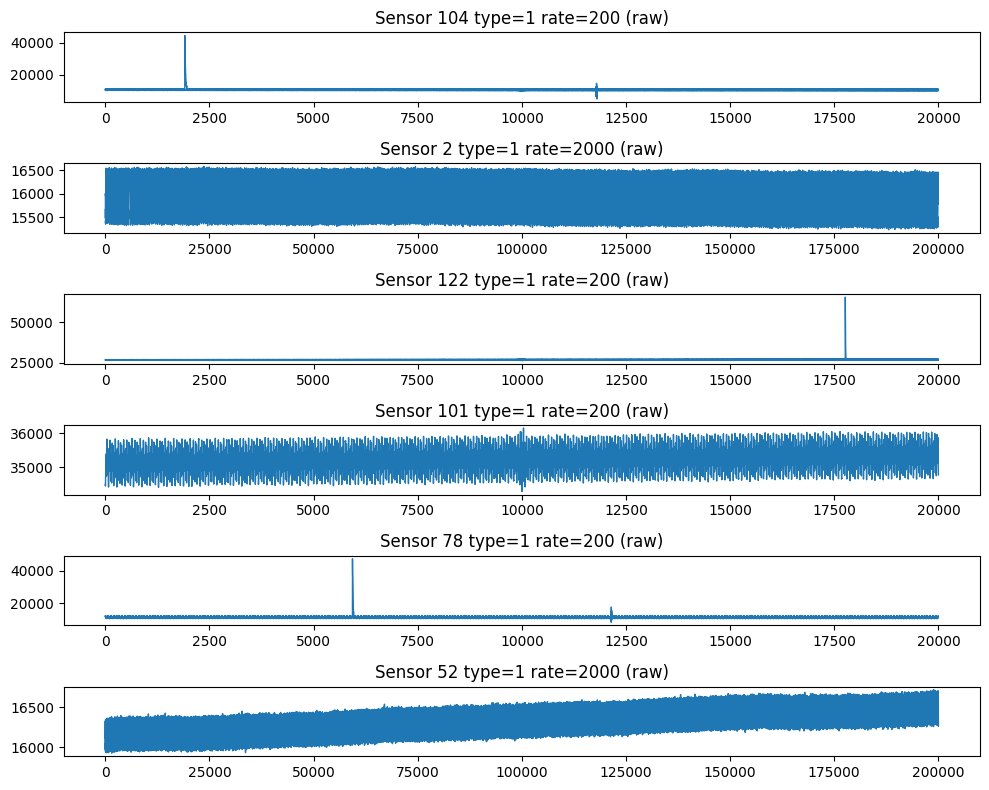

In [ ]:
if __name__ == "__main__":
    # parameters
    N = 200
    duration = 100.0  # seconds
    rates = [200]  # 단일화: 200Hz만 사용
    seed = 123

    anomaly_cfg = {
        'prob_segment': 0.6,
        'seg_len_sec': (0.01, 0.3),
        'types': ['spike', 'drift', 'stuck', 'noiseburst']
    }

    sensors_by_rate, sensors = generate_multimodal_data_advanced(
        num_sensors=N,
        duration_sec=duration,
        rates=rates,
        prob_1word=0.33,
        prob_2word=0.33,
        prob_bits=0.34,
        seed=seed,
        anomaly_cfg=anomaly_cfg
    )

    quick_summary(sensors_by_rate)

    # Create dataset and dataloader from flattened sensors
    ds = MoEMultiSensorDataset(sensors, to_torch=True)
    dl = DataLoader(ds, batch_size=8, shuffle=True, collate_fn=lambda x: x)

    # Plot 6 random sensors raw (no aligned data anymore)
    import matplotlib.pyplot as plt
    fig, axs = plt.subplots(6,1, figsize=(10,8))
    picks = np.random.choice(len(sensors), size=6, replace=False)
    for i,p in enumerate(picks):
        plot_sensor_signal(sensors[p], which='raw', ax=axs[i])
    plt.tight_layout()
    plt.show()


In [ ]:
# -----------------------------
# Example usage / sanity check
# -----------------------------
if __name__ == "__main__":
    # parameters
    N = 200
    duration = 100.0  # seconds
    rates = [200]  # 단일화: 200Hz만 사용
    seed = 123

    anomaly_cfg = {
        'prob_segment': 0.6,
        'seg_len_sec': (0.01, 0.3),
        'types': ['spike', 'drift', 'stuck', 'noiseburst']
    }

    sensors_by_rate, sensors = generate_multimodal_data_advanced(
        num_sensors=N,
        duration_sec=duration,
        rates=rates,
        prob_1word=0.33,
        prob_2word=0.33,
        prob_bits=0.34,
        seed=seed,
        anomaly_cfg=anomaly_cfg
    )

    quick_summary(sensors_by_rate)

    # Create dataset and dataloader from flattened sensors
    ds = MoEMultiSensorDataset(sensors, to_torch=True)
    dl = DataLoader(ds, batch_size=8, shuffle=True, collate_fn=lambda x: x)

    # Plot 6 random sensors raw (no aligned data anymore)
    import matplotlib.pyplot as plt
    fig, axs = plt.subplots(6,1, figsize=(10,8))
    picks = np.random.choice(len(sensors), size=6, replace=False)
    for i,p in enumerate(picks):
        plot_sensor_signal(sensors[p], which='raw', ax=axs[i])
    plt.tight_layout()
    plt.show()

    # Print one sensor details
    idx = 0
    s0 = sensors[idx]
    print("Sensor 0 sample (first 20 raw):", s0['raw_signal'][:20])
    print("Meta:", s0['meta'])
    print("Anomalies:", s0['anomalies'])

    # Demonstrate using dataloader: print a batch's raw shapes
    batch = next(iter(dl))
    print("Batch size:", len(batch))
    print("Example item keys:", batch[0].keys())
    print("Example raw tensor shape:", batch[0]['raw_signal'].shape)


# =======================
# Example Execution 2
# =======================
    data, labels, meta = generate_multimodal_data(
        num_sensors=20,
        seq_len=50,
        seed=42
    )

    print("Data shape:", data.shape)
    for i, m in enumerate(meta[:10]):
        print(f"{i} → label={labels[i]}, meta={m}")

'''
Output
1 = 1word
2 = 2word (MSB/LSB pair)
3 = bits


{
  'type': '2word',
  'role': 'LSB',
  'pair': 5
}
{
  'type': 'bits',
  'bit_start': 3,
  'bit_end': 7,
  'bit_width': 5
}
{
  'type': '1word',
  'bit_start': 0,
  'bit_end': 15
}
'''
